# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

This notebook specifically focuses on mu200 data for training and evaluation.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

In [2]:
# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn

# Local imports
from graph import load_graphs, SparseGraph, feature_scale, graph_from_sparse
from model import SegmentClassifier
from estimator import Estimator

%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Data utilities

In [4]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

## Prepare the data

In [5]:
input_dir = '/global/cscratch1/sd/sfarrell/heptrkx/hit_graphs_mu200_000/data'

In [6]:
n_samples = 100

In [7]:
%%time

filenames = [os.path.join(input_dir, 'event%06i.npz' % i) for i in range(n_samples)]
graphs = load_graphs(filenames, SparseGraph)

CPU times: user 545 ms, sys: 404 ms, total: 950 ms
Wall time: 5.22 s


### What is the class balance of this sample set?

In [8]:
# Get the mean label for all the segments from all samples

# Flatten the labels array
flat_y = np.concatenate([g.y for g in graphs])

flat_y.mean()

0.1620198

## Visualize one sample

This likely won't work because there is too much activity in the event.
I might need to develop a way to visualize just part of the event, like a geometric slice.

In [9]:
i = 0
graph = graph_from_sparse(graphs[i])

In [10]:
graph.X.shape, graph.y.shape

((13111, 3), (57752,))

## Define data generator

Since every event is unique, we need something which can batch things together into batch-specific tensors.

It should just use the max size required for that sample.

In [11]:
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [graph_from_sparse(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            #print('  data prepared')
            yield batch_inputs, batch_target

## Define the model

Copying it here for now as I play with things

In [12]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        #print('EdgeNetwork bmm bo')
        bo = torch.bmm(Ro.transpose(1, 2), X)
        #print('EdgeNetwork bmm bi')
        bi = torch.bmm(Ri.transpose(1, 2), X)
        #print('EdgeNetwork concatenate B')
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        #print('EdgeNetwork apply sequential module')
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        #print('NodeNetwork bmm bo')
        bo = torch.bmm(Ro.transpose(1, 2), X)
        #print('NodeNetwork bmm bi')
        bi = torch.bmm(Ri.transpose(1, 2), X)
        #print('NodeNetwork mul Rwo', Ro.size(), e.size(), e[:,None].size())
        # I don't know if this will work, or be any faster
        #Rwo = torch.mul(Ro, e[:,None])
        Rwo = Ro * e[:,None]
        #print('NodeNetwork mul Rwi', Ri.size(), e.size(), e[:,None].size())
        # I don't know if this will work, or be any faster
        #Rwi = torch.mul(Ri, e[:,None])
        Rwi = Ri * e[:,None]
        #print('NodeNetwork bmm mi', Rwi.size(), bo.size())
        mi = torch.bmm(Rwi, bo)
        #print('NodeNetwork bmm mo', Rwo.size(), bi.size())
        mo = torch.bmm(Rwo, bi)
        #print('NodeNetwork concatenate M')
        M = torch.cat([mi, mo, X], dim=2)
        #print('NodeNetwork apply sequential module')
        return self.network(M)

class SegmentClassifier(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        #print('X', X.size(), 'Ri', Ri.size(), 'Ro', Ro.size())
        # Apply input network to get hidden representation
        #print('Applying input network')
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        #print('Concatenating inputs to hidden state')
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            #print('Graph iteration', i)
            # Apply edge network
            #print('Applying edge network')
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            #print('Applying node network')
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            #print('Concatenating inputs to hidden state')
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## Train the model

In [13]:
# Model config
hidden_dim = 32
n_iters = 4

# Training config
batch_size = 1
n_epochs = 4
valid_frac = 0.2
test_frac = 0.2

In [14]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(60, 20, 20, 100)

In [15]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 60
Valid set size: 20
Test set size:  20


In [16]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)
test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)

In [17]:
# Construct the model
n_features = feature_scale.shape[0]
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-04-19 14:10:17.889190 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32)
      (3): Tanh()
    )
  )
)
2018-04-19 14:10:17.889637 Parameters: 6881


In [ ]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, verbose=1)

2018-04-19 14:10:33.863619 Epoch 0
2018-04-19 14:12:06.025649   Batch 0 loss 0.699536
2018-04-19 14:13:53.630440   Batch 1 loss 0.665593
2018-04-19 14:15:11.818259   Batch 2 loss 0.640426
2018-04-19 14:17:19.546753   Batch 3 loss 0.607825
2018-04-19 14:18:52.244557   Batch 4 loss 0.597289
2018-04-19 14:20:42.862761   Batch 5 loss 0.566488
2018-04-19 14:22:18.777538   Batch 6 loss 0.553490
2018-04-19 14:24:03.975165   Batch 7 loss 0.532136
2018-04-19 14:25:30.446842   Batch 8 loss 0.520299
2018-04-19 14:26:26.637133   Batch 9 loss 0.526140
2018-04-19 14:28:49.513911   Batch 10 loss 0.469983
2018-04-19 14:29:59.306512   Batch 11 loss 0.491316
2018-04-19 14:31:15.040129   Batch 12 loss 0.477651
2018-04-19 14:33:55.746723   Batch 13 loss 0.427177
2018-04-19 14:36:19.032507   Batch 14 loss 0.420644
2018-04-19 14:37:51.687769   Batch 15 loss 0.437479
2018-04-19 14:39:02.710462   Batch 16 loss 0.453476
2018-04-19 14:40:03.474258   Batch 17 loss 0.464222
2018-04-19 14:42:18.587374   Batch 18 l

### Loss curves

<IPython.core.display.Javascript object>


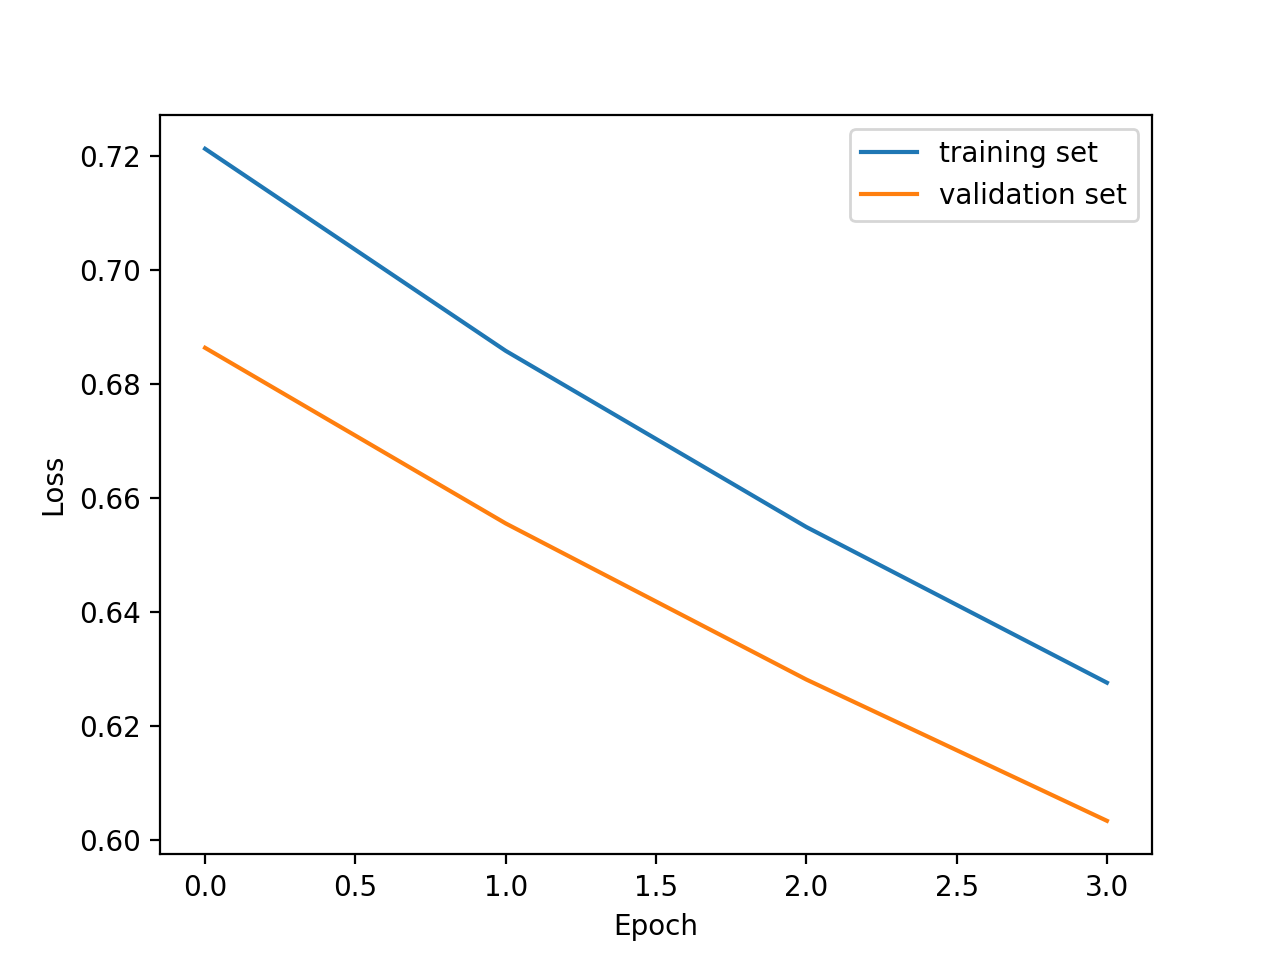

In [25]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate model on the test set

In [21]:
test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)

In [22]:
test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
test_preds = [torch_to_np(o) for o in test_outputs]

In [23]:
# Flatten the predictions and labels
flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
flat_pred = np.concatenate([p.flatten() for p in test_preds])

In [24]:
thresh = 0.5
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

Test set results with threshold of 0.5
Accuracy:  0.8118
Precision: 0.4299
Recall:    0.0424


In [25]:
# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

<IPython.core.display.Javascript object>


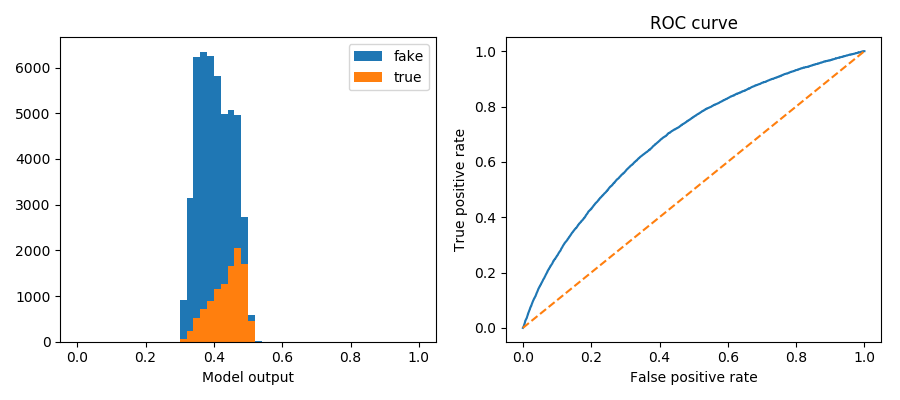

In [26]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

accuracy 0.984, precision 0.987, recall 0.987


<IPython.core.display.Javascript object>


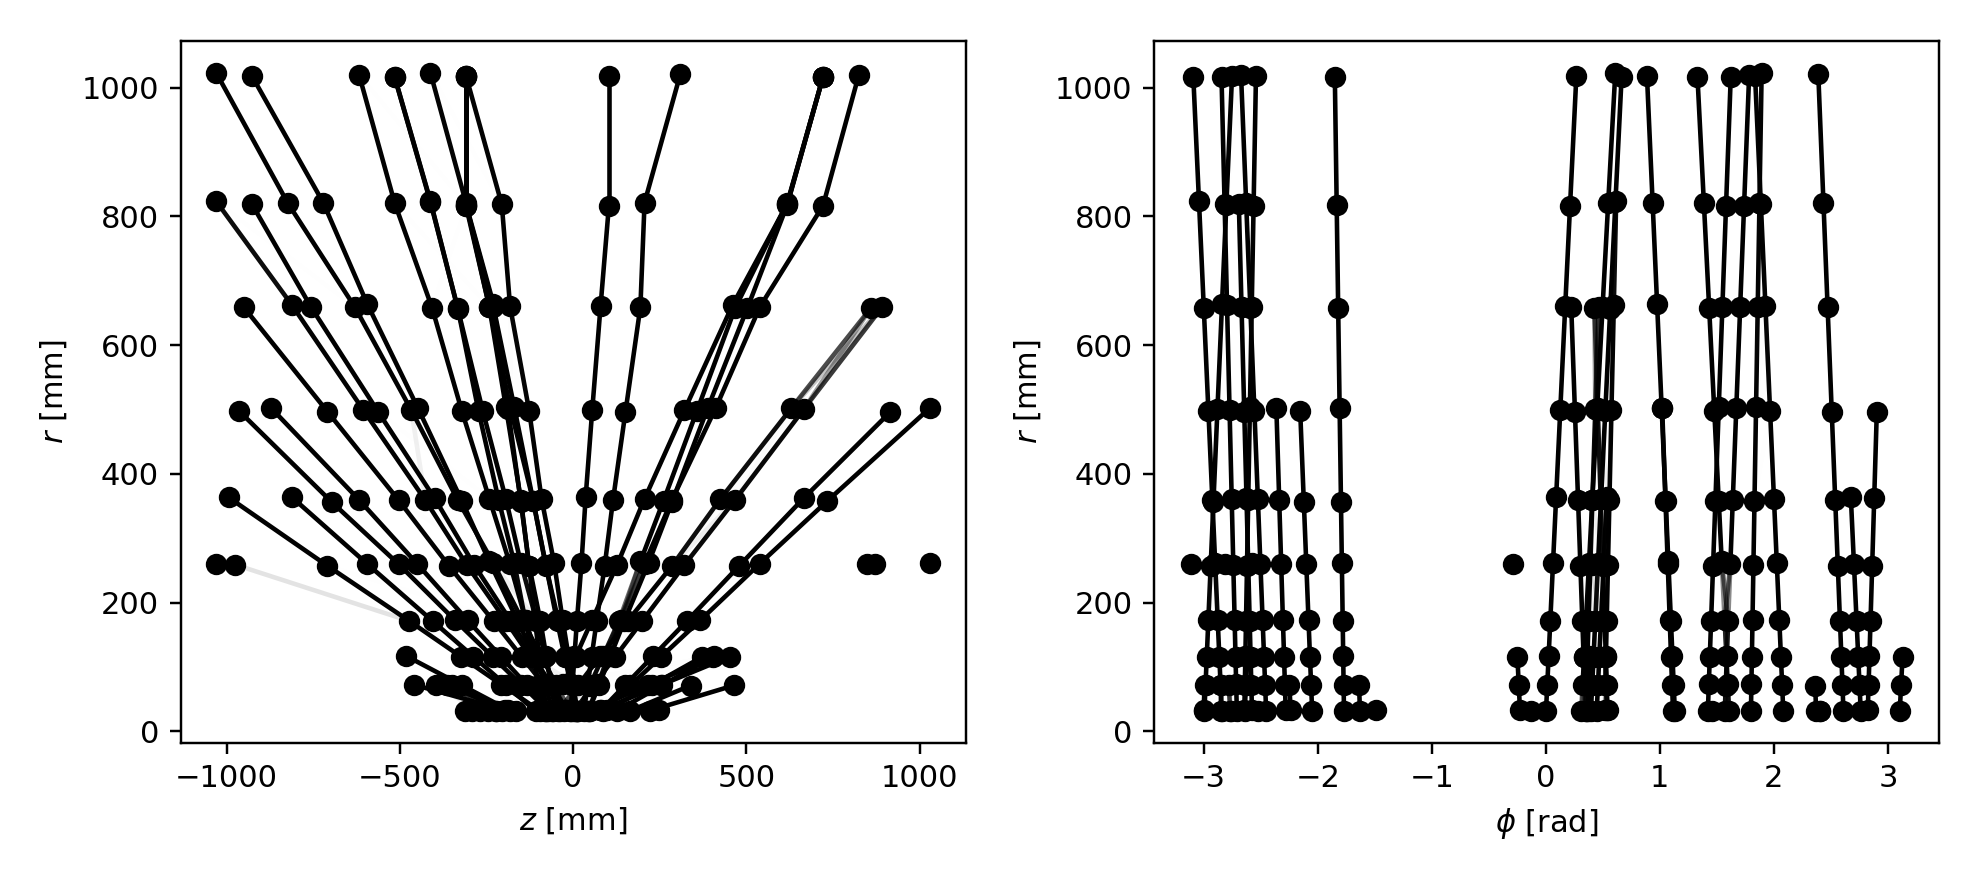

accuracy 0.958, precision 0.965, recall 0.954


<IPython.core.display.Javascript object>


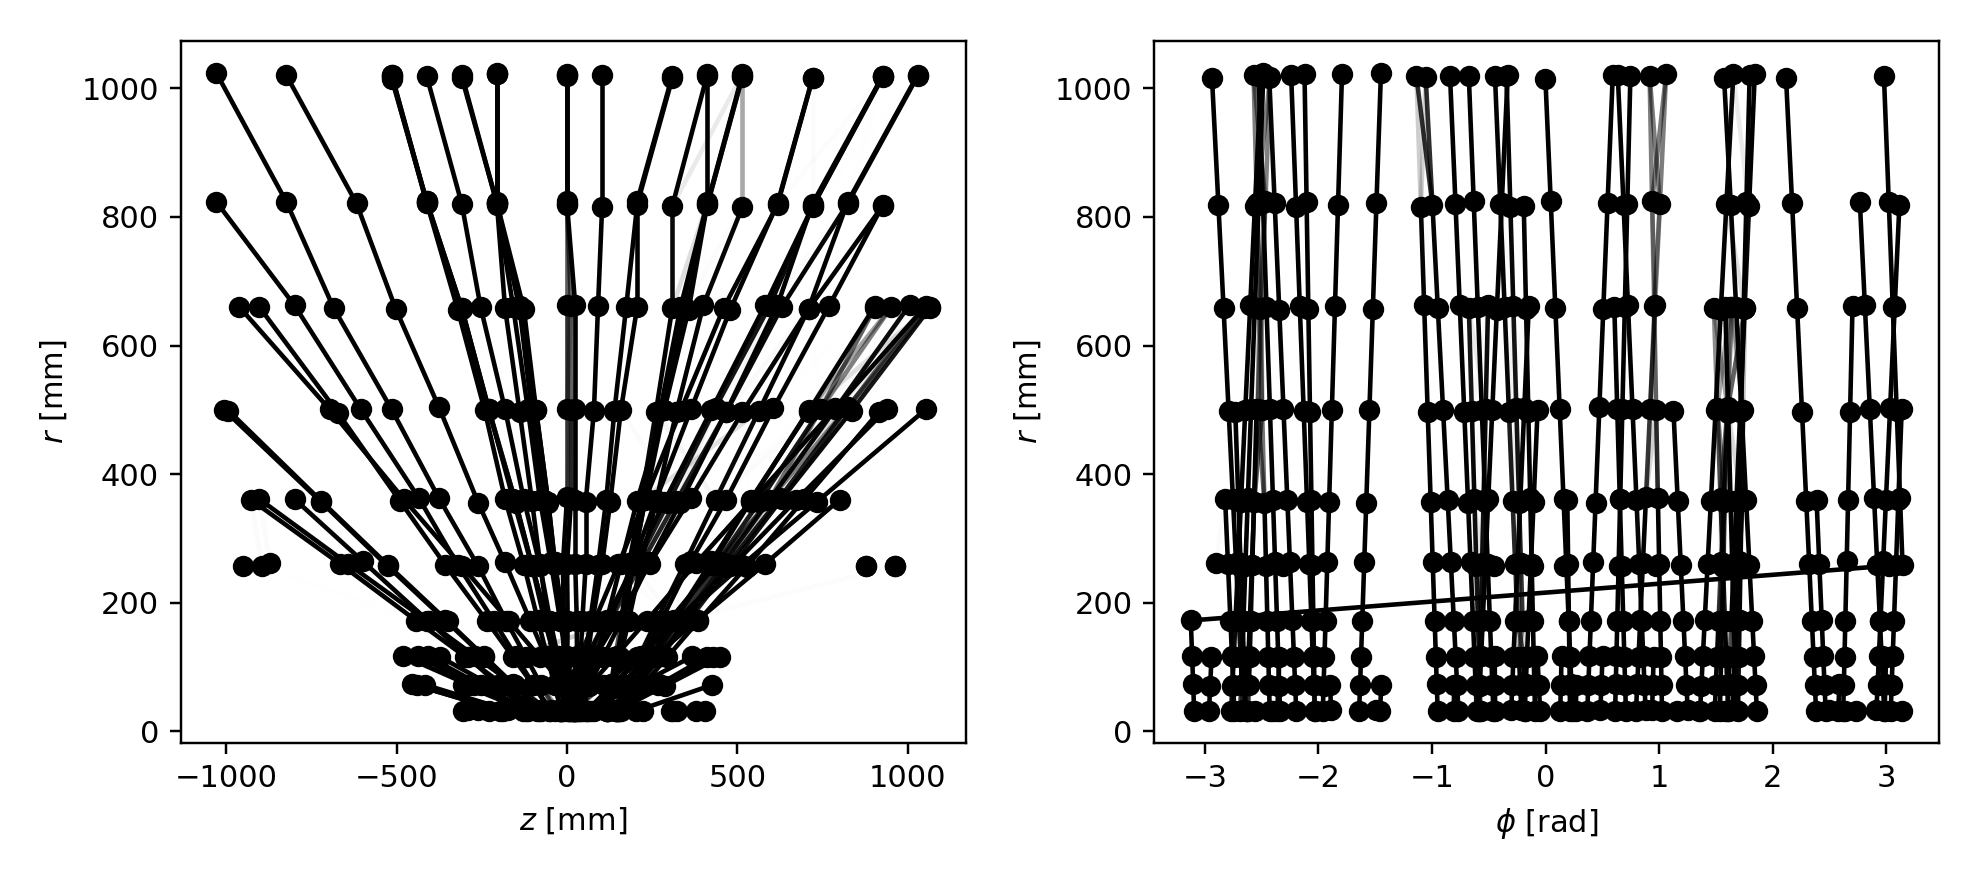

accuracy 0.955, precision 0.948, recall 0.953


<IPython.core.display.Javascript object>


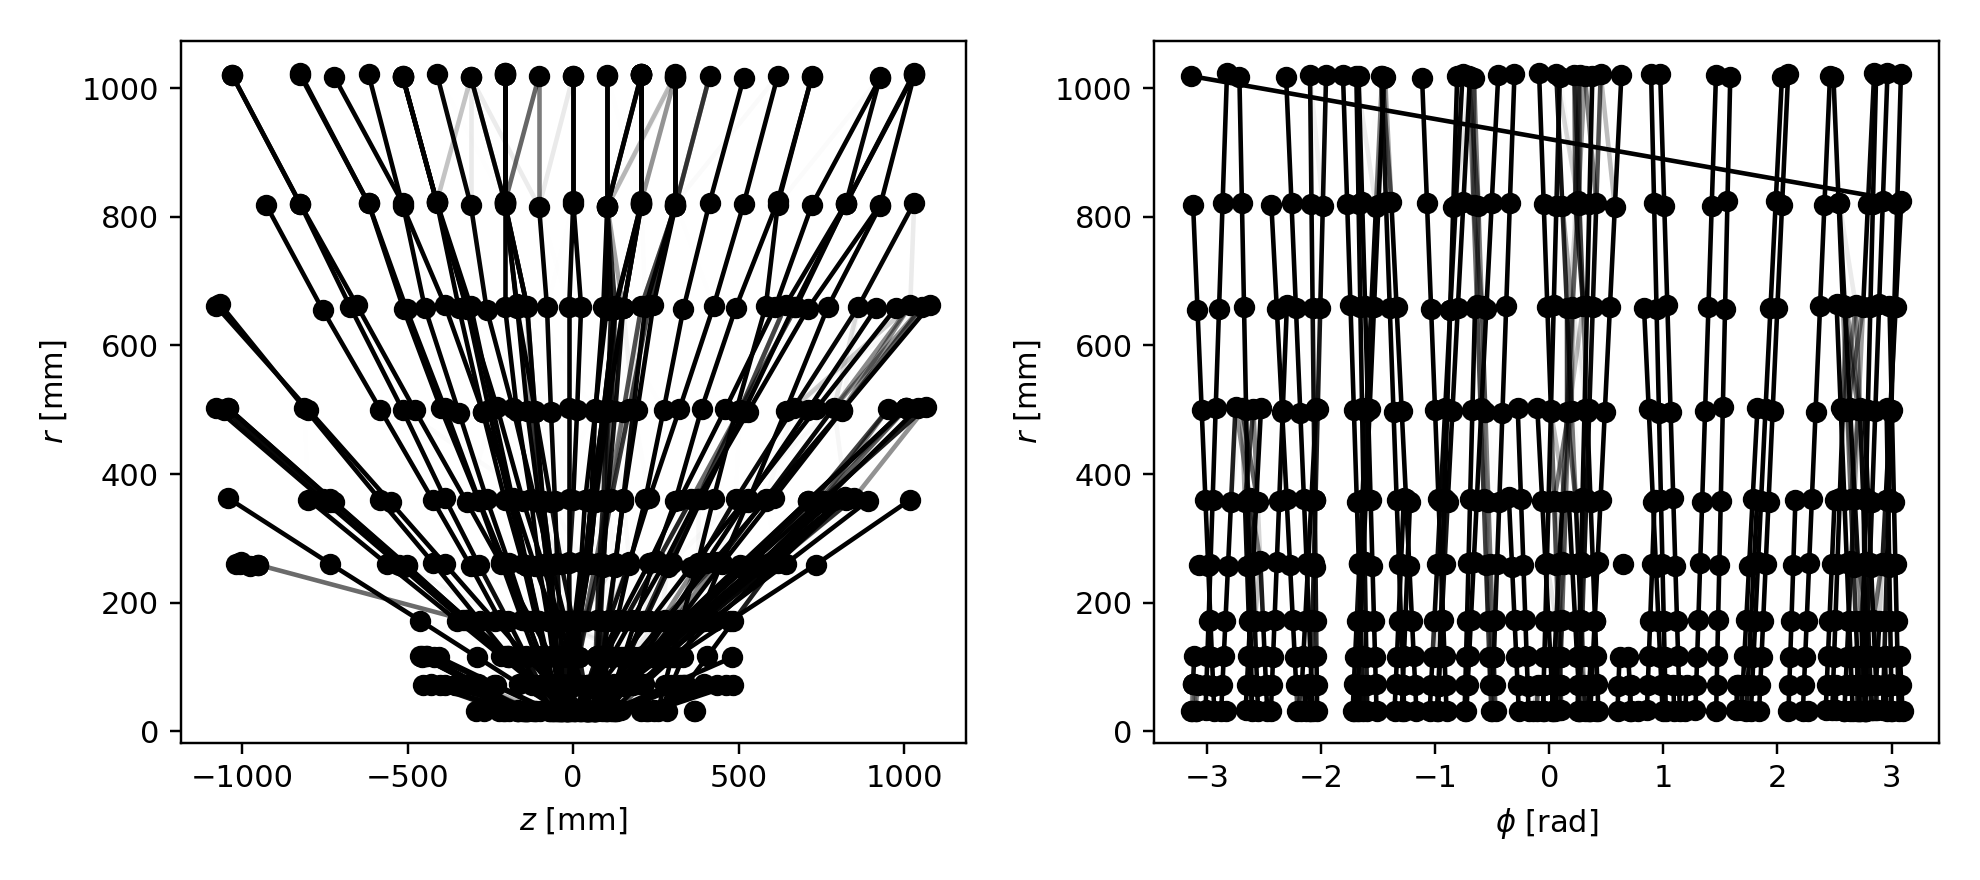

accuracy 0.989, precision 0.987, recall 0.997


<IPython.core.display.Javascript object>


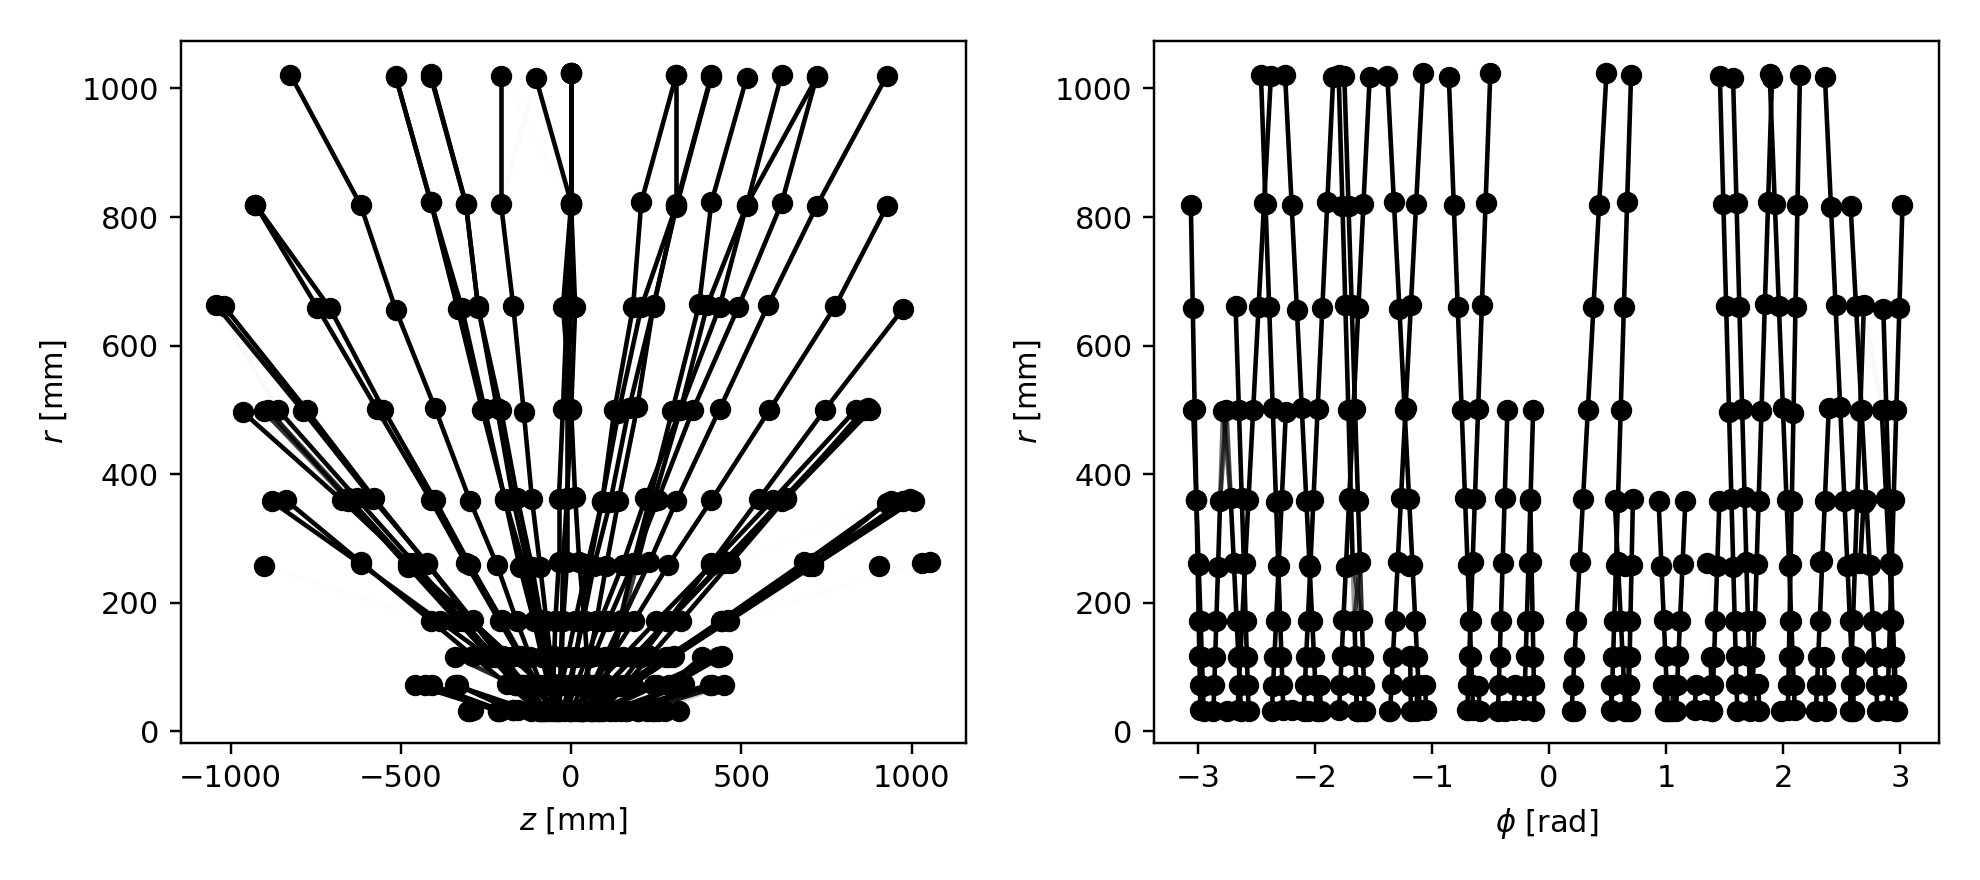

In [24]:
# Draw some samples
for i in range(4):
    g = graph_from_sparse(test_graphs[i])
    pred = test_preds[i].squeeze(0)
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(g.y, pred>thresh),
        sklearn.metrics.precision_score(g.y, pred>thresh),
        sklearn.metrics.recall_score(g.y, pred>thresh)))
    draw_sample(g.X*feature_scale, g.Ri, g.Ro, pred, alpha_labels=True);